## Import Libraries

In [16]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import clear_output

import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras import Model, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications import MobileNet
from keras.applications.densenet import DenseNet121
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub

# Little Configuration
np.set_printoptions(linewidth=np.inf)

# Mencetak versi TensorFlow yang sedang digunakan
print(f"Tensorflow Version : {tf.__version__}")
print(f"keras Version      : {keras.__version__}")
print([device for device in tf.config.list_physical_devices()][0])
print([device for device in tf.config.list_physical_devices()][1])

Tensorflow Version : 2.13.0
keras Version      : 2.13.1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Print Bold
def bold (text):
    return "\033[1m" + str(text) + '\033[0m'

## Data Loading

In [4]:
# Linux Path
# dataset_path = "/mnt/7E3A592A3A58E127/DBS/Dataset/Animal Image Dataset"

# Windows Path
dataset_path = "../Dataset/Animal Image Dataset/"

In [5]:
#  Create Animal Dictionary
animal_dict = {}
for label in os.listdir(dataset_path):
    animal_dict[label] = os.listdir(os.path.join(dataset_path, label))
# print(animal_dict['cats'])

In [6]:
# Print Dataset Info
print(f"Dataset has {bold(len(animal_dict.keys()))} labels : {[label for label in animal_dict.keys()]}")
print(f"Total Images : {bold(sum([len(value) for value in animal_dict.values()]))}")
# for key, value in animal_dict.items():
    # print("{} belongs to {}".format(bold(str(len(value))), bold(key)))

Dataset has 12 labels : ['butterfly', 'cats', 'cow', 'dogs', 'elephant', 'hen', 'horse', 'monkey', 'panda', 'sheep', 'spider', 'squirrel']
Total Images : 17178


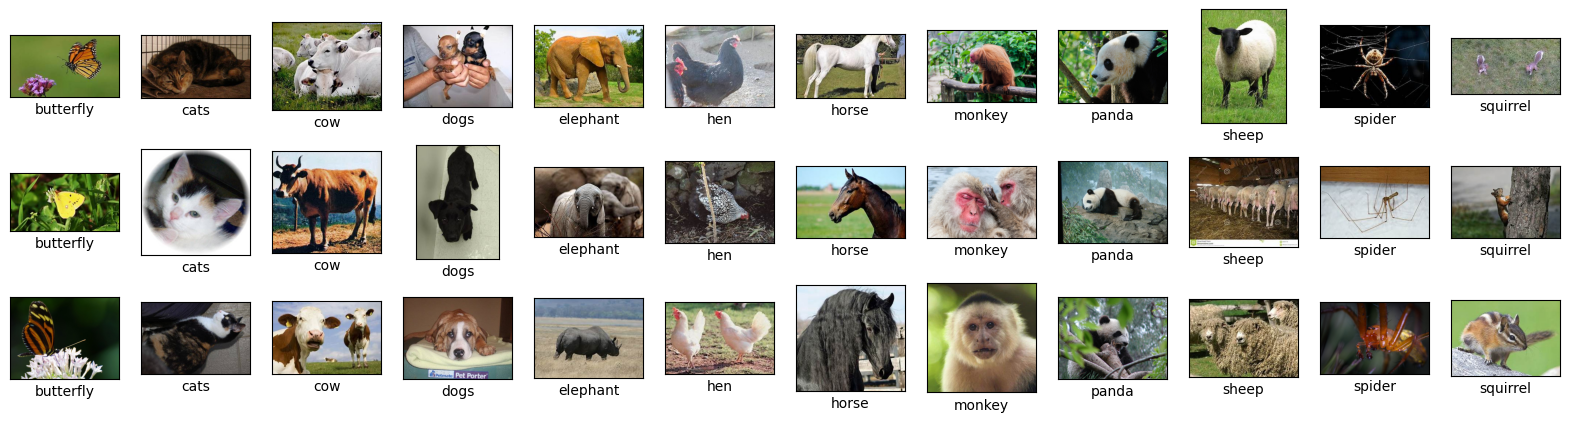

In [7]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(3, len(animal_dict.keys()), figsize=(20, 5))

for i, label in enumerate(animal_dict.keys()):
    images = np.random.choice(animal_dict[label], 3, replace=False)
    
    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, label, image_name)
        img = Image.open(img_path)
        axs[j, i].imshow(img)
        axs[j, i].set(xlabel=label, xticks=[], yticks=[])
# fig.tight_layout()

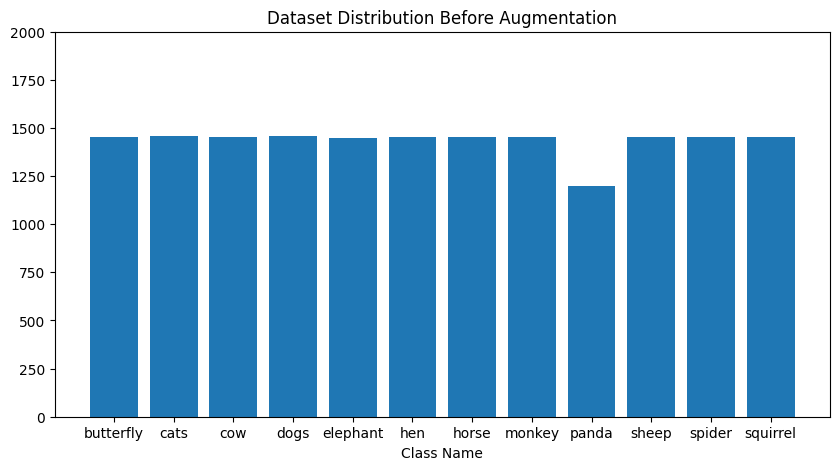

In [8]:
# Distributuin Plot
data_label, data_count = [], []
for key, value in animal_dict.items():
    data_label.append(key)
    data_count.append(len(value))
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(data_label, data_count)
ax.set_ylim(0, 2000)
ax.set_xlabel('Class Name')
ax.set_title('Dataset Distribution Before Augmentation')
plt.show()

## Data Augmentation

### Augmentation Functions

In [9]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)
 
# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)
 
# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)
 
# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img
 
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)
 
# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image
 
# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [10]:
# Augmentation Function Dict
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

### Apply Augmentation

In [12]:
for key, value in animal_dict.items():
    # print(len(value), key)
    images_path = os.path.join(dataset_path, key)
    augmented_path = images_path
    images = []
    
    for image in os.listdir(images_path):
        images.append(os.path.join(images_path, image))
        
    images_to_generate = 1500
    i = len(value) + 1
    
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)

            # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            transformed_image = None
            n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
            transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

            while n <= transformation_count:
                aug_func = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
                clear_output(wait=True)
                print(key)
                print(aug_func)
                print(image)
                time.sleep(0.0001)
                transformed_image = transformations[aug_func](original_image)
                n = n + 1

            new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
            transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
            cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
            i = i + 1
            time.sleep(0.05)
        except ValueError as e:
            print('Failed', aug_func, image, ':', e, 'hence skipping it.')

squirrel
rotate anticlockwise
../Dataset/Animal Image Dataset/squirrel/OIP-heuAW5GcuarsKRzQXC9RjgHaFj.jpeg


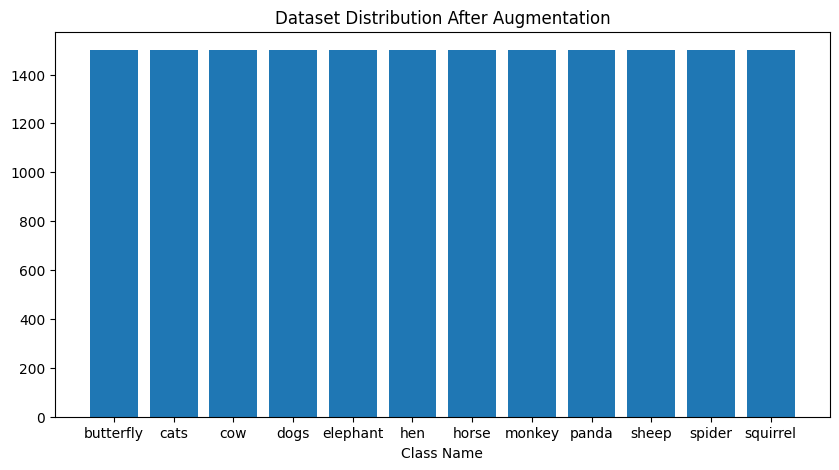

In [13]:
# Update Animal Dictionary
for label in os.listdir(dataset_path):
    animal_dict[label] = os.listdir(os.path.join(dataset_path, label))

# Distributuin Plot
data_label, data_count = [], []
for key, value in animal_dict.items():
    data_label.append(key)
    data_count.append(len(value))
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(data_label, data_count)
ax.set_xlabel('Class Name')
ax.set_title('Dataset Distribution After Augmentation')
plt.show()

## Image Data Generator

In [25]:
datagen = ImageDataGenerator(
    rescale = 1/255.,           # Normalization
    validation_split = 0.2      # Validation Split = 20%
)

X_train = datagen.flow_from_directory(
    dataset_path,
    batch_size=64,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

X_valid = datagen.flow_from_directory(
    dataset_path,
    batch_size=32,
    target_size=(224,224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 14400 images belonging to 12 classes.
Found 3600 images belonging to 12 classes.


## Modeling

### Callbacks

In [7]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
            self.model.stop_training=True
            print('\nModel telah mencapai akurasi 95%')

### CNN Model

In [ ]:
tf.keras.backend.clear_session()

class_num = len(animal_dict.keys())

####################### Init sequential model ##################################
model = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())
# 1nd Dense Layer
model.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model.add(Dropout(0.5))
# 2nd Dense Layer
model.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model.add(Dense(class_num, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model.summary())

In [ ]:
%time
# Fitting / training model
history = model.fit(
    X_train,
    epochs=10,
    batch_size=32,
    validation_data=X_valid,
    steps_per_epoch=60,
    callbacks=myCallback()
)

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["accuracy"], label="training")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [ ]:
model.save('./model/cnnV1.h5')

### Pretrained Layer mobilenetV2

In [ ]:
tf.keras.backend.clear_session()

class_num = len(animal_dict.keys())

mobilenetV2 = Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-feature-vector/2", input_shape=(224, 224, 3), trainable=False),
    Dense(class_num, activation='softmax')
])

mobilenetV2.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss=keras.losses.CategoricalCrossentropy(),
                            metrics=['accuracy'])

mobilenetV2.summary()

In [ ]:
from keras.utils import plot_model

plot_model(mobilenetV2, show_shapes=True, show_layer_names=True)

In [ ]:
epoch_num = 10
history_mobilenetV2 = mobilenetV2.fit(
    X_train, 
    epochs=10,
    batch_size=32,
    validation_data=X_valid,
    callbacks=myCallback()
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_mobilenetV2.history["accuracy"], label="training")
axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_mobilenetV2.history["val_accuracy"], label="validation")
axs[1].plot(history_mobilenetV2.history["loss"], label="training")
axs[1].plot(history_mobilenetV2.history["val_loss"], label="validation")
plt.legend()

In [ ]:
eva = mobilenetV2.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

In [ ]:
mobilenetV2.save('./model/mobilenetV2-140-224.h5')

### Pretrained Model MobileNetV2

In [7]:
# tf.keras.backend.clear_session()

from keras.applications.mobilenet_v2 import MobileNetV2

mobilenetv2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# mobilenetv2.summary()

# Freeze Layer
for layer in mobilenetv2.layers:
    layer.trainable = False

# Adding Layers
class_num = len(animal_dict.keys())
model_mobilenet = Sequential([
    mobilenetv2,
    Conv2D(32, (5, 5),padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(class_num, activation='softmax')
])

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          1024032   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 64)                1

In [8]:
epoch_num = 100
history_mobilenet = model_mobilenet.fit(
    X_train, 
    epochs=epoch_num,
    validation_data=X_valid,
    callbacks=myCallback()
)

                                     
                                     
    █▀▀▀▀▀█ ▄█ ▄▄█▄▄▄ █▀█ █▀▀▀▀▀█    
    █ ███ █ ▄█▀█ ▄▀▄▀▄▄▄  █ ███ █    
    █ ▀▀▀ █ ▄ █ ▀ ▀▄▀█▀▀▀ █ ▀▀▀ █    
    ▀▀▀▀▀▀▀ ▀ ▀ █ █ █ █▄▀ ▀▀▀▀▀▀▀    
    ██▀██▄▀▀██▀ ▀▀▄ ▄▀▄▄█▀▄█▄▀ ▀▄    
    █▄█▀██▀▀▄█▄█▀ ▄█▀▀▀▄█▄ █ ▄ ▄     
    ███▄▄ ▀ ▀█▄▀▄▀▄ ▄█▄█▄▄▄▄▄▀▀ ▄    
      ▄▀▄▀▀█ ▄▀ ▄▀▀▀▄▀   ▀▀▄ ▀▀▄     
    ████▄█▀▄ ▀█ ▀▀▄ ▄█▄▄█▄▄▄▄▀█ ▄    
    █ ▄▀▄▀▀█▄▄██▀▀██▀   ▀▄▄▄▀ ▀▄     
    ▀  ▀▀▀▀ █  ▀▄█▄ ▄██ █▀▀▀█▄███    
    █▀▀▀▀▀█ ▀█▀ ▄ ▄█▀▀ ██ ▀ █▀▀ ▄    
    █ ███ █ █▄█ ▀▀▄▀▄▀  █▀▀▀▀▄███    
    █ ▀▀▀ █ █ ▀█▀▀█▀  ▄▀█▄████▀█     
    ▀▀▀▀▀▀▀ ▀▀ ▀▀  ▀▀▀     ▀  ▀      
                                     
                                     
https://mlnotify.aporia.com/training/116797

Scan the QR code or enter the url to get a notification when your training is done


Epoch 1/100
450/450 [==============================] - 151s 321ms/step - loss: 3.9943 - accuracy: 0.1063 - val_loss: 2.4056 - val_accuracy: 0.1758
E

Failed to run a plugin's `after` function [<mlnotify.plugins.notify.NotifyPlugin object at 0x7fb67d246410>]
Traceback (most recent call last):
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-packages/urllib3/connection.py", line 196, in _new_conn
    sock = connection.create_connection(
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-

In [12]:
epoch_num = 100
history_mobilenet = model_mobilenet.fit(
    X_train, 
    epochs=epoch_num,
    validation_data=X_valid,
    callbacks=myCallback()
)

Failed to run a plugin's `before` function [<mlnotify.plugins.notify.NotifyPlugin object at 0x7fb67d246410>]
Traceback (most recent call last):
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-packages/urllib3/connection.py", line 196, in _new_conn
    sock = connection.create_connection(
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/home/yelf/.pyenv/tf2.13/lib/python3.10/site

Epoch 1/100
450/450 [==============================] - 134s 298ms/step - loss: 0.2926 - accuracy: 0.9073 - val_loss: 0.2421 - val_accuracy: 0.9269
Epoch 2/100
450/450 [==============================] - 132s 295ms/step - loss: 0.2779 - accuracy: 0.9131 - val_loss: 0.2433 - val_accuracy: 0.9272
Epoch 3/100
450/450 [==============================] - 131s 292ms/step - loss: 0.2834 - accuracy: 0.9112 - val_loss: 0.2434 - val_accuracy: 0.9258
Epoch 4/100
450/450 [==============================] - 131s 290ms/step - loss: 0.2846 - accuracy: 0.9087 - val_loss: 0.2413 - val_accuracy: 0.9269
Epoch 5/100
450/450 [==============================] - 131s 291ms/step - loss: 0.2834 - accuracy: 0.9091 - val_loss: 0.2410 - val_accuracy: 0.9275
Epoch 6/100
450/450 [==============================] - 130s 288ms/step - loss: 0.2822 - accuracy: 0.9128 - val_loss: 0.2395 - val_accuracy: 0.9278
Epoch 7/100
450/450 [==============================] - 132s 294ms/step - loss: 0.2683 - accuracy: 0.9175 - val_loss: 0

In [ ]:
model_mobilenet.save('./model/mobilenetV2_NN_100epoch.h5')

113/113 [==============================] - 29s 249ms/step - loss: 0.2447 - accuracy: 0.9261
Model Evaluasi (Akurasi) : 92.61%
Model Evaluasi (loss)    : 24.47%


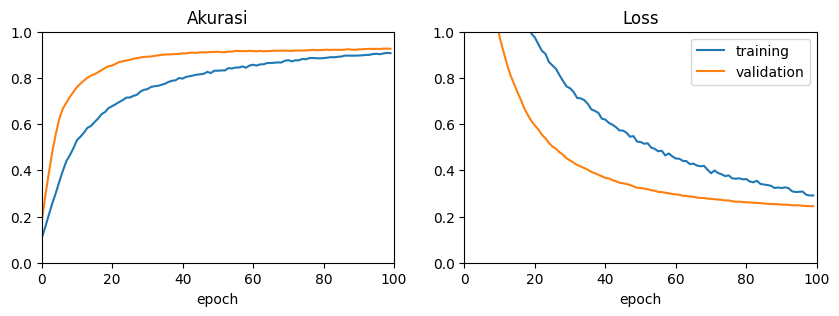

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_mobilenet.history["accuracy"], label="training")
axs[0].plot(history_mobilenet.history["val_accuracy"], label="validation")

axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[1].plot(history_mobilenet.history["loss"], label="training")
axs[1].plot(history_mobilenet.history["val_loss"], label="validation")

plt.legend()

eva = model_mobilenet.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

### Pretrained Model Resnet50

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2

resnet50V2 = ResNet50V2(
                weights='imagenet', 
                include_top=False,
                input_shape=(224, 224, 3),
                # pooling='max'
)

# resnet50V2.summary()

In [ ]:
# Freeze Layer
for layer in resnet50V2.layers:
    layer.trainable = False

# Adding Layers
class_num = len(animal_dict.keys())
model_resnet = Sequential([
    resnet50V2,
    Conv2D(32, (7, 7),padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(class_num, activation='softmax')
])

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

model_resnet.summary()

In [ ]:
epoch_num = 10
history_resnet = model_resnet.fit(
    X_train, 
    epochs=30,
    batch_size=64,
    validation_data=X_valid,
    callbacks=myCallback()
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_resnet.history["accuracy"], label="training")
axs[0].plot(history_resnet.history["val_accuracy"], label="validation")

axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[1].plot(history_resnet.history["loss"], label="training")
axs[1].plot(history_resnet.history["val_loss"], label="validation")

plt.legend()

In [ ]:
eva = model_resnet.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

In [ ]:
model_resnet.save('./model/resnet50V2.h5')

### InceptionV3

#### Define Model

In [30]:
# tf.keras.backend.clear_session()

from keras.applications import InceptionV3

inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299,299,3)
)

# freeze layers inception
for layer in inceptionV3.layers:
    layer.trainable = False
    
# inceptionV3.summary()

# Adding Layers
class_num = len(animal_dict.keys())
model_inceptionV3 = Sequential([
    inceptionV3,
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(class_num, activation='softmax')
])

model_inceptionV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

model_inceptionV3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_284 (Conv2D)         (None, 6, 6, 128)         2359424   
                                                                 
 global_average_pooling2d_2  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                1548      
                                                      

#### Training

In [31]:
epoch_num = 100
history_inceptionV3 = model_inceptionV3.fit(
    X_train, 
    epochs=epoch_num,
    validation_data=X_valid,
    callbacks=myCallback()
)

Epoch 1/100
225/225 [==============================] - 142s 606ms/step - loss: 1.2454 - accuracy: 0.6215 - val_loss: 0.4351 - val_accuracy: 0.9022
Epoch 2/100
225/225 [==============================] - 137s 608ms/step - loss: 0.4679 - accuracy: 0.8748 - val_loss: 0.2923 - val_accuracy: 0.9286
Epoch 3/100
225/225 [==============================] - 138s 615ms/step - loss: 0.3445 - accuracy: 0.9074 - val_loss: 0.2463 - val_accuracy: 0.9369
Epoch 4/100
225/225 [==============================] - 138s 614ms/step - loss: 0.2836 - accuracy: 0.9230 - val_loss: 0.2211 - val_accuracy: 0.9414
Epoch 5/100
225/225 [==============================] - 138s 612ms/step - loss: 0.2451 - accuracy: 0.9342 - val_loss: 0.2090 - val_accuracy: 0.9417
Epoch 6/100
225/225 [==============================] - 138s 614ms/step - loss: 0.2290 - accuracy: 0.9379 - val_loss: 0.2012 - val_accuracy: 0.9436
Epoch 7/100
225/225 [==============================] - 136s 606ms/step - loss: 0.1976 - accuracy: 0.9445 - val_loss: 0

#### Accuracy and Loss Plot

113/113 [==============================] - 31s 270ms/step - loss: 0.1793 - accuracy: 0.9528
Model Evaluasi (Akurasi) : 95.28%
Model Evaluasi (loss)    : 17.93%


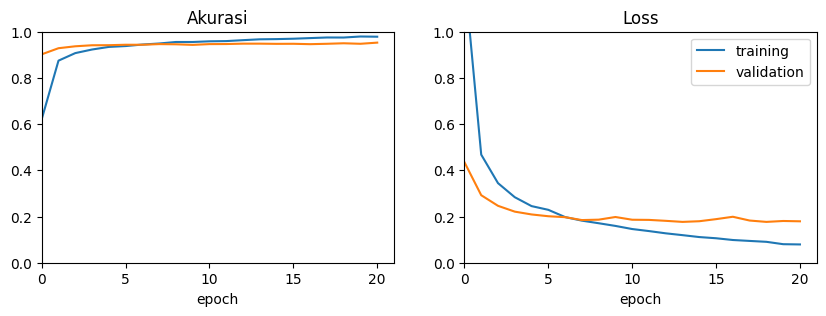

In [36]:
epoch_num = 21
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history_inceptionV3.history["accuracy"], label="training")
axs[0].plot(history_inceptionV3.history["val_accuracy"], label="validation")

axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[1].plot(history_inceptionV3.history["loss"], label="training")
axs[1].plot(history_inceptionV3.history["val_loss"], label="validation")

plt.legend()

eva = model_inceptionV3.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

#### Save Model

##### Save model with h5 format

In [ ]:
model_inceptionV3.save('./model/inceptionV3.h5')

##### Save model with SavedModel

In [39]:
save_path = './model/'
tf.saved_model.save(model_inceptionV3, save_path)

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


#### Convert Model to TensorflowJS

In [72]:
# Convert model.h5 to tensorflowjs
# !tensorflowjs_converter --input_format=keras './models/inceptionV3.h5' tfjs_mode

# Convert SavedModel to tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model /model /tfjs_mode

##### Convert Model to Tensorflow Lite

In [76]:
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model('./model/')
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./tflite/vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

96647540